**数据预处理**

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# 读取数据
need_date_time_columns=1 #是否需要时间作为特征
columns_to_drop=[] #需要删除的列
df = pd.read_csv('data//train.csv', parse_dates=['DateTime'])
# 转换所有应为数值的列为 float（防止字符串类型报错）
numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'RR', 'NBJRR1', 'NBJRR5', 'NBJRR10', 'NBJBROU'
]
# 强制转换为 float，如果有无法解析的值，设置为 NaN
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=numeric_cols, inplace=True)

df=df.drop(columns=columns_to_drop)
# 添加日期列
df['Date'] = df['DateTime'].dt.date  # 只保留年月日部分

# 计算 sub_metering_remainder（每分钟）
df['sub_metering_remainder'] = (df['Global_active_power'] * 1000 / 60) - (
    df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

# 定义日级聚合函数
daily_agg = {
    'Global_active_power': 'sum' ,
    'Global_reactive_power': 'sum',
    'Sub_metering_1': 'sum',  # 已是 Wh，每分钟累计可以直接 sum
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'sub_metering_remainder': 'sum',

    'Voltage': 'mean',  # 电压波动，均值即可
    'Global_intensity': 'mean',  # 电流均值也合理

    'RR': 'first',  # 天气指标，一天一个值即可
    'NBJRR1': 'first',
    'NBJRR5': 'first',
    'NBJRR10': 'first',
    'NBJBROU': 'first'
}
for col in columns_to_drop:
    daily_agg.pop(col, None)

# 按日期聚合
df_daily = df.groupby('Date').agg(daily_agg).reset_index()
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
if need_date_time_columns:
    # 可以选择将日期列转回 datetime 类型
    df_daily['day_of_week'] = df_daily['Date'].dt.dayofweek  # 0=Monday
    df_daily['day_of_month'] = df_daily['Date'].dt.day
    df_daily['month'] = df_daily['Date'].dt.month
    df_daily['quarter'] = df_daily['Date'].dt.quarter
# 查看结果
print("预处理后日级数据：")
print(df_daily.info())
print(df_daily.head())
feature_cols = [col for col in df_daily.columns if col != 'Date']
scaler = MinMaxScaler()
df_daily_scaled = df_daily.copy()
df_daily_scaled[feature_cols] = scaler.fit_transform(df_daily[feature_cols])
print(df_daily_scaled.head())

预处理后日级数据：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    746 non-null    datetime64[ns]
 1   Global_active_power     746 non-null    float64       
 2   Global_reactive_power   746 non-null    float64       
 3   Sub_metering_1          746 non-null    float64       
 4   Sub_metering_2          746 non-null    float64       
 5   Sub_metering_3          746 non-null    float64       
 6   sub_metering_remainder  746 non-null    float64       
 7   Voltage                 746 non-null    float64       
 8   Global_intensity        746 non-null    float64       
 9   RR                      746 non-null    float64       
 10  NBJRR1                  746 non-null    float64       
 11  NBJRR5                  746 non-null    float64       
 12  NBJRR10                 746 non-null    

In [7]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# target_col = 'Global_active_power'
# # 计算皮尔逊相关系数矩阵
# corr_matrix = df_daily[feature_cols + [target_col]].corr()
#
# # 可视化热力图
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
# plt.title("Pearson Correlation Matrix")
# plt.tight_layout()
# plt.show()

In [8]:
# from sklearn.feature_selection import mutual_info_regression
#
# X = df_daily[feature_cols]
# y = df_daily[target_col]
#
# mi_scores = mutual_info_regression(X, y, random_state=0)
# mi_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
#
# # 可视化
# plt.figure(figsize=(10, 5))
# mi_series.plot(kind='bar', color='darkorange')
# plt.title(f'Mutual Information with Target: {target_col}')
# plt.ylabel('MI Score')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


构造监督学习数据集+Transformer模型设计+训练函数

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
head_size=128
num_heads=8
ff_dim=256
num_transformer_blocks=2
dropout=0.1

def create_supervised_data(df, input_window=90, output_window=90, target_col='Global_active_power'):
    """
    构造用于多变量时间序列预测的监督学习样本
    参数：
        df: 已按天聚合的 DataFrame，包含时间序列特征
        input_window: 输入时间步长（例如 90）
        output_window: 预测步长（例如 90 或 365）
        target_col: 预测目标列
    返回：
        X: shape = [样本数, input_window, 特征数]
        y: shape = [样本数, output_window]
    """
    data = df.copy()
    feature_cols = [col for col in data.columns if col != 'Date']

    X_list = []
    y_list = []

    for i in range(len(data) - input_window - output_window + 1):
        x_window = data[feature_cols].iloc[i : i + input_window].values
        y_window = data[target_col].iloc[i + input_window : i + input_window + output_window].values

        if not (np.isnan(x_window).any() or np.isnan(y_window).any()):
            X_list.append(x_window)
            y_list.append(y_window)

    X = np.array(X_list)
    y = np.array(y_list)
    return X, y

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        pos = np.arange(sequence_length)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # 多头注意力层

    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])  # 残差连接
    x = LayerNormalization(epsilon=1e-6)(x)

    # 前馈网络
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

def build_transformer_model(input_timesteps, num_features, output_timesteps,
                            head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, num_transformer_blocks=num_transformer_blocks, dropout=dropout):
    inputs = Input(shape=(input_timesteps, num_features))
    x = PositionalEncoding(input_timesteps, num_features)(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # 可以取最后一个时间步，或者全局平均（更稳定）
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(output_timesteps)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def train_transformer_model(X_train, y_train, X_val, y_val,
                     input_timesteps, num_features, output_timesteps,
                     epochs=50, batch_size=64, n_runs=5):
    from tensorflow.keras import backend as K

    mse_list = []
    mae_list = []
    best_model = None
    best_mse = float('inf')

    for run in range(n_runs):
        print(f"\n===== Run {run+1}/{n_runs} =====")
        model = build_transformer_model(input_timesteps, num_features, output_timesteps)

        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),  # 显式验证集
            callbacks=[early_stopping],
            verbose=2
        )

        # 验证集评估（用于模型选择）
        loss, mae = model.evaluate(X_val, y_val, verbose=0)
        mse = loss

        print(f"Run {run+1} - MSE: {mse:.6f}, MAE: {mae:.6f}")

        mse_list.append(mse)
        mae_list.append(mae)

        if mse < best_mse:
            best_mse = mse
            best_model = model

        K.clear_session()

    results = {
        'mse_mean': np.mean(mse_list),
        'mse_std': np.std(mse_list),
        'mae_mean': np.mean(mae_list),
        'mae_std': np.std(mae_list),
    }

    print("\n===== Summary =====")
    print(f"MSE mean: {results['mse_mean']:.6f}, std: {results['mse_std']:.6f}")
    print(f"MAE mean: {results['mae_mean']:.6f}, std: {results['mae_std']:.6f}")

    return best_model, results

开始训练

In [10]:
epochs=100
n_runs=10
batch_size=32
input_window = 90
output_window = 365
target_col = 'Global_active_power'

X_full, y_full = create_supervised_data(df_daily_scaled, input_window, output_window, target_col)
print(f"X shape: {X_full.shape}, y shape: {y_full.shape}")
print(f"原始日级数据总天数: {df_daily.shape[0]}")
print(f"用于建模的样本数: {len(X_full)}")

# 划分训练集和验证集
train_ratio = 0.9
split_idx = int(len(X_full) * train_ratio)
X_train, X_val = X_full[:split_idx], X_full[split_idx:]
y_train, y_val = y_full[:split_idx], y_full[split_idx:]

print(f"训练集样本数: {len(X_train)}, 验证集样本数: {len(X_val)}")

num_features = X_train.shape[2]

model, results = train_transformer_model(
    X_train, y_train, X_val, y_val,
    input_window, num_features, output_window,
    epochs=epochs, batch_size=batch_size, n_runs=n_runs
)
model.summary()

X shape: (292, 90, 17), y shape: (292, 365)
原始日级数据总天数: 746
用于建模的样本数: 292
训练集样本数: 262, 验证集样本数: 30

===== Run 1/10 =====
Epoch 1/100
9/9 - 3s - 343ms/step - loss: 0.1284 - mae: 0.3149 - val_loss: 0.0993 - val_mae: 0.2723
Epoch 2/100
9/9 - 1s - 58ms/step - loss: 0.0904 - mae: 0.2524 - val_loss: 0.0661 - val_mae: 0.2090
Epoch 3/100
9/9 - 1s - 59ms/step - loss: 0.0603 - mae: 0.1967 - val_loss: 0.0406 - val_mae: 0.1591
Epoch 4/100
9/9 - 1s - 60ms/step - loss: 0.0385 - mae: 0.1539 - val_loss: 0.0278 - val_mae: 0.1303
Epoch 5/100
9/9 - 1s - 59ms/step - loss: 0.0266 - mae: 0.1280 - val_loss: 0.0228 - val_mae: 0.1197
Epoch 6/100
9/9 - 1s - 60ms/step - loss: 0.0213 - mae: 0.1150 - val_loss: 0.0218 - val_mae: 0.1172
Epoch 7/100
9/9 - 1s - 59ms/step - loss: 0.0198 - mae: 0.1112 - val_loss: 0.0222 - val_mae: 0.1193
Epoch 8/100
9/9 - 1s - 59ms/step - loss: 0.0184 - mae: 0.1070 - val_loss: 0.0220 - val_mae: 0.1179
Epoch 9/100
9/9 - 1s - 59ms/step - loss: 0.0178 - mae: 0.1055 - val_loss: 0.0215 - val_m

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 90, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 90, 17)    │          0 │ input_layer[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 90, 17)    │     72,721 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 90, 17)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 90, 17)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 90, 17)    │         34 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90, 256)   │      4,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 90, 256)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 90, 17)    │      4,369 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 90, 17)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 17)    │         34 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 90, 17)    │     72,721 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 90, 17)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 90, 17)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 90, 17)    │         34 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 90, 256)   │      4,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 90, 256)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 90, 17)    │      4,369 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 90, 17)    │          0 │ dense_3[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 510,308 (1.95 MB)

 Trainable params: 170,102 (664.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 340,206 (1.30 MB)

测试集+作图

C:\Users\16693\AppData\Local\Temp\ipykernel_28008\169990766.py:3: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv('data/test.csv', header=None)


清洗后测试集天数: 684
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


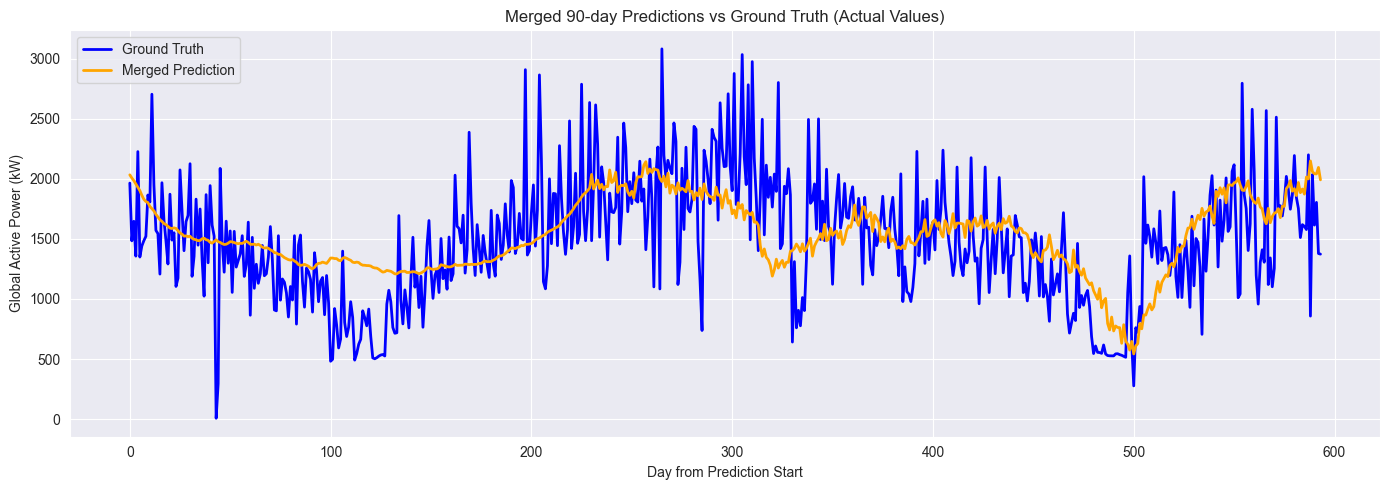

Day | Ground Truth (kW) | Merged Prediction (kW) | Absolute Error
--------------------------------------------------
  0 |         1964.8620 |           2033.7213 |        68.8593
  1 |         1484.2600 |           2007.3979 |       523.1379
  2 |         1646.8900 |           1985.3484 |       338.4584
  3 |         1356.8940 |           1957.9051 |       601.0111
  4 |         2227.0560 |           1931.3917 |       295.6643
  5 |         1349.3880 |           1902.4313 |       553.0433
  6 |         1441.8820 |           1862.9064 |       421.0244
  7 |         1485.5940 |           1829.7142 |       344.1202
  8 |         1521.7620 |           1811.0829 |       289.3209
  9 |         1865.6280 |           1802.9821 |        62.6459
 10 |         1807.1940 |           1770.5432 |        36.6508
 11 |         2704.5620 |           1751.5880 |       952.9740
 12 |         1951.8580 |           1733.4059 |       218.4521
 13 |         1571.4640 |           1705.0456 |       133.5816
 

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
df_test = pd.read_csv('data/test.csv', header=None)

# Step 2：赋完整列名（按顺序）
df_test.columns = ["DateTime"]+numeric_cols


# 数值列转换（如有非数字或缺失，转为NaN）
df_test[numeric_cols] = df_test[numeric_cols].apply(pd.to_numeric, errors='coerce')
# 显式删除不需要字段
df_test = df_test.drop(columns=columns_to_drop)
df_test['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df_test['Date'] = df_test['DateTime'].dt.date

# 计算 sub_metering_remainder
df_test['sub_metering_remainder'] = (df_test['Global_active_power'] * 1000 / 60) - (
    df_test['Sub_metering_1'] + df_test['Sub_metering_2'] + df_test['Sub_metering_3'])

# 按天聚合
df_test_daily = df_test.groupby('Date').agg(daily_agg).reset_index()
if need_date_time_columns:
    df_test_daily['Date'] = pd.to_datetime(df_test_daily['Date'])
    df_test_daily['day_of_week'] = df_daily['Date'].dt.dayofweek  # 0=Monday
    df_test_daily['day_of_month'] = df_daily['Date'].dt.day
    df_test_daily['month'] = df_daily['Date'].dt.month
    df_test_daily['quarter'] = df_daily['Date'].dt.quarter
# ========== 关键修改点：丢弃含NaN的天 ==========
df_test_daily_clean = df_test_daily.dropna()
print(f"清洗后测试集天数: {len(df_test_daily_clean)}")

# 归一化（只对干净数据做）
df_test_daily_scaled = df_test_daily_clean.copy()
df_test_daily_scaled[feature_cols] = scaler.transform(df_test_daily_scaled[feature_cols])


def inverse_transform_target(scaler, feature_cols, data_1d, target_col='Global_active_power'):
    """
    把一维的目标列数据逆归一化。
    scaler: 训练时fit的Scaler
    feature_cols: 归一化时所有特征的列名列表
    data_1d: 目标列的一维归一化数据（如full_pred或full_true）
    返回：逆归一化后目标列一维数据
    """
    n = len(data_1d)
    temp = np.zeros((n, len(feature_cols)))
    # 找到目标列索引
    target_idx = feature_cols.index(target_col)
    temp[:, target_idx] = data_1d
    # 逆归一化
    inv_data = scaler.inverse_transform(temp)
    return inv_data[:, target_idx]


X_test_final, y_test_final = create_supervised_data(
    df_test_daily_scaled,
    input_window=input_window,
    output_window=output_window,
    target_col=target_col  # 一般是 'Global_active_power'
)
y_pred_final = model.predict(X_test_final)
# print("测试集天数(原始日数据):", len(df_test_daily_scaled))
# print("测试集每日特征缺失情况:\n", df_test_daily_scaled.isna().sum())
# print("预测窗口数(样本数):", len(y_pred_final))
# print("预测窗口中有缺失值样本丢弃数:", (len(df_test_daily_scaled) - input_window - output_window + 1) - len(y_pred_final))


# 初始化容器
total_days = input_window + (len(y_pred_final) - 1) + output_window
pred_sum = np.zeros(total_days)
true_sum = np.zeros(total_days)
# pred_count = np.zeros(total_days)
# true_count = np.zeros(total_days)
#
# # 多窗口预测融合
# for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
#     start_idx = input_window + i
#     end_idx = start_idx + output_window
#
#     pred_sum[start_idx:end_idx] += pred
#     pred_count[start_idx:end_idx] += 1
#
#     true_sum[start_idx:end_idx] += true
#     true_count[start_idx:end_idx] += 1
#
# # 平均融合
# pred_avg = np.zeros_like(pred_sum)
# true_avg = np.zeros_like(true_sum)
#
# pred_avg[pred_count > 0] = pred_sum[pred_count > 0] / pred_count[pred_count > 0]
# true_avg[true_count > 0] = true_sum[true_count > 0] / true_count[true_count > 0]

# 替代平均融合：取最后一次预测
for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
    start_idx = input_window + i
    end_idx = start_idx + output_window

    pred_sum[start_idx:end_idx] = pred  # 直接覆盖
    true_sum[start_idx:end_idx] = true
# for i, (pred, true) in enumerate(zip(y_pred_final, y_test_final)):
#     start_idx = input_window + i
#     end_idx = start_idx + output_window
#
#     for j in range(output_window):
#         idx = start_idx + j
#         if pred_count[idx] == 0:
#             pred_sum[idx] = pred[j]
#             true_sum[idx] = true[j]
#             pred_count[idx] = 1
#             true_count[idx] = 1
# 取预测部分
full_pred = pred_sum[input_window:]
full_true = true_sum[input_window:]

# 反归一化
full_pred_inv = inverse_transform_target(scaler, feature_cols, full_pred, target_col)
full_true_inv = inverse_transform_target(scaler, feature_cols, full_true, target_col)

# 时间轴
days = np.arange(len(full_pred))

plt.figure(figsize=(14, 5))
plt.plot(days, full_true_inv, label='Ground Truth', color='blue', linewidth=2)
plt.plot(days, full_pred_inv, label='Merged Prediction', color='orange', linewidth=2)
plt.xlabel('Day from Prediction Start')
plt.ylabel('Global Active Power (kW)')  # 单位改成实际单位
plt.title('Merged 90-day Predictions vs Ground Truth (Actual Values)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
true_values_to_show = full_true_inv
pred_values_to_show = full_pred_inv

# 打印前30天（或根据需要改）
print("Day | Ground Truth (kW) | Merged Prediction (kW) | Absolute Error")
print("-" * 50)
for i in range(min(30, len(true_values_to_show))):
    true_val = true_values_to_show[i]
    pred_val = pred_values_to_show[i]
    error = abs(true_val - pred_val)
    print(f"{i:3d} | {true_val:17.4f} | {pred_val:19.4f} | {error:14.4f}")



# MSE
mse = mean_squared_error(true_values_to_show, pred_values_to_show)

# RMSE
rmse = mse ** 0.5

# MAE
mae = mean_absolute_error(true_values_to_show, pred_values_to_show)
errors = pred_values_to_show- true_values_to_show
std_dev = np.std(errors)

print(f"测试集评估指标:")
print(f"MSE : {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"预测误差标准差: {std_dev:.6f}")

In [12]:

# days2 = np.arange(90)
# plt.figure(figsize=(14, 5))
# plt.plot(days2, y_test_final[1], label='Ground Truth', color='blue', linewidth=2)
# plt.plot(days2, y_pred_final[1], label='Merged Prediction', color='orange', linestyle='--', linewidth=2)
# plt.xlabel('Day from Prediction Start')
# plt.ylabel('Global Active Power (kW)')  # 单位改成实际单位
# plt.title('90-day Predictions vs Ground Truth')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()